In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset,Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [21]:
file_path = 'train_set.xlsx'
data_train = pd.read_excel(file_path)

In [22]:
file_path = 'val_set.xlsx'
data_val = pd.read_excel(file_path)

In [23]:
file_path = 'test_set.xlsx'
data_test = pd.read_excel(file_path)

In [55]:
wave_test = data_test.iloc[:, 5:1029].values 
temperature_test = data_test['temperature,oc'].values
fre_test = data_test['frequency,Hz'].values
c_loss_test = data_test['core loss,w/m3'].values
material_test = data_test['material type'].values
wavetype_test = data_test['excitation waveform'].values

wave_val = data_val.iloc[:, 5:1029].values 
temperature_val = data_val['temperature,oc'].values
fre_val = data_val['frequency,Hz'].values
c_loss_val = data_val['core loss,w/m3'].values
material_val = data_val['material type'].values
wavetype_val = data_val['excitation waveform'].values

wave_train = data_train.iloc[:, 5:1029].values 
temperature_train = data_train['temperature,oc'].values
fre_train = data_train['frequency,Hz'].values
c_loss_train = data_train['core loss,w/m3'].values
material_train = data_train['material type'].values
wavetype_train = data_train['excitation waveform'].values

In [57]:
scaler = StandardScaler()
temperature_train_scaled = scaler.fit_transform(temperature_train.reshape(-1, 1))
fre_train_scaled = scaler.fit_transform(fre_train.reshape(-1, 1))
temperature_train = torch.tensor(temperature_train_scaled, dtype=torch.float32)
fre_train = torch.tensor(fre_train_scaled, dtype=torch.float32)
wave_train = torch.tensor(wave_train, dtype=torch.float32)
material_train = torch.tensor(material_train-1, dtype=torch.long)
wavetype_train = torch.tensor(wavetype_train-1, dtype=torch.long)
c_loss_train = torch.tensor(c_loss_train, dtype=torch.float32)

temperature_val_scaled = scaler.fit_transform(temperature_val.reshape(-1, 1))
fre_val_scaled = scaler.fit_transform(fre_val.reshape(-1, 1))
temperature_val = torch.tensor(temperature_val_scaled, dtype=torch.float32)
fre_val = torch.tensor(fre_val_scaled, dtype=torch.float32)
wave_val = torch.tensor(wave_val, dtype=torch.float32)
material_val = torch.tensor(material_val-1, dtype=torch.long)
wavetype_val = torch.tensor(wavetype_val-1, dtype=torch.long)
c_loss_val = torch.tensor(c_loss_val, dtype=torch.float32)

temperature_test_scaled = scaler.fit_transform(temperature_test.reshape(-1, 1))
fre_test_scaled = scaler.fit_transform(fre_test.reshape(-1, 1))
temperature_test = torch.tensor(temperature_test_scaled, dtype=torch.float32)
fre_test = torch.tensor(fre_test_scaled, dtype=torch.float32)
wave_test = torch.tensor(wave_test, dtype=torch.float32)
material_test = torch.tensor(material_test-1, dtype=torch.long)
wavetype_test = torch.tensor(wavetype_test-1, dtype=torch.long)
c_loss_test = torch.tensor(c_loss_test, dtype=torch.float32)

In [59]:
# 自定义数据集
class CoreLossDataset(Dataset):
    def __init__(self, temperature, fre, material, wavetype, wave, c_loss):
        self.material = material
        self.fre = fre
        self.temperature = temperature
        self.wavetype = wavetype
        self.wave = wave
        self.c_loss = c_loss

    def __len__(self):
        return len(self.c_loss)

    def __getitem__(self, idx):
        return (self.material[idx], 
                self.temperature[idx], 
                self.fre[idx], 
                self.wave[idx], 
                self.wavetype[idx], 
                self.c_loss[idx])

In [65]:
class MixedNN(nn.Module):
    def __init__(self):
        super(MixedNN, self).__init__()
        
        self.material_embedding = nn.Embedding(4, 4)  
        self.wavetype_embedding = nn.Embedding(3, 3)  
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv_output_size = 32 * (1024 // 4)  

        self.fc1 = nn.Linear(self.conv_output_size + 4 + 3 + 2, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  

    def forward(self, material, temperature, fre, wave, wavetype):
        material_embedded = self.material_embedding(material)
        wavetype_embedded = self.wavetype_embedding(wavetype)
        
        wave = wave.unsqueeze(1) 
        wave = self.pool(torch.relu(self.conv1(wave)))
        wave = self.pool(torch.relu(self.conv2(wave)))
        wave = wave.view(wave.size(0), -1)  

        x = torch.cat([wave, material_embedded, wavetype_embedded, temperature, fre], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)  
        return output

In [61]:
#train val test
dataset_train = CoreLossDataset(temperature_train, fre_train, material_train, wavetype_train, wave_train, c_loss_train)
dataset_val = CoreLossDataset(temperature_val, fre_val, material_val, wavetype_val, wave_val, c_loss_val)
dataset_test = CoreLossDataset(temperature_test, fre_test, material_test, wavetype_test, wave_test, c_loss_test)

In [148]:
def train_model(dataset, model, criterion, optimizer, val_dataset, epochs=1000,patience=20):
    train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=16, shuffle=False)

    best_val_loss = float('inf') 
    patience_counter = 0  
    
    for epoch in range(epochs):
        model.train()
        for temperature, fre, material, wavetype, wave, c_loss in train_dataloader:
            outputs = model(temperature, fre, material, wavetype, wave)
            loss = criterion(outputs.squeeze(), c_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        loss_train.append(loss.item())

        model.eval()
        val_loss = 0.0
        with torch.no_grad():  
            for temperature, fre, material, wavetype, wave, c_loss in val_dataloader:
                outputs = model(temperature, fre, material, wavetype, wave)
                val_loss += criterion(outputs.squeeze(), c_loss).item()

        val_loss /= len(val_dataloader)  
        print(f'Val Loss: {val_loss:.4f}')
        loss_val.append(val_loss) 

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break  

In [162]:
model = MixedNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [164]:
loss_train = [] 
loss_val = [] 
train_model(dataset_train, model, criterion, optimizer, dataset_val, epochs=1000, patience=50)

Epoch [1/1000], Loss: 445188833280.0000
Val Loss: 139146135291.6610
Epoch [2/1000], Loss: 111662727168.0000
Val Loss: 80291411413.6949
Epoch [3/1000], Loss: 150833840128.0000
Val Loss: 80088386039.3220
Epoch [4/1000], Loss: 136831492096.0000
Val Loss: 76346840392.6780
Epoch [5/1000], Loss: 72648343552.0000
Val Loss: 79001203472.2712
Epoch [6/1000], Loss: 196106780672.0000
Val Loss: 76062891165.2881
Epoch [7/1000], Loss: 57395191808.0000
Val Loss: 76433752449.6271
Epoch [8/1000], Loss: 3025555968.0000
Val Loss: 75590744686.6441
Epoch [9/1000], Loss: 52231049216.0000
Val Loss: 75956880978.4407
Epoch [10/1000], Loss: 19943913472.0000
Val Loss: 75544460795.6610
Epoch [11/1000], Loss: 64404770816.0000
Val Loss: 75049887454.3729
Epoch [12/1000], Loss: 24956565504.0000
Val Loss: 74248327621.4237
Epoch [13/1000], Loss: 54964031488.0000
Val Loss: 74806362213.4237
Epoch [14/1000], Loss: 37879132160.0000
Val Loss: 74086488367.1864
Epoch [15/1000], Loss: 137478471680.0000
Val Loss: 73396159307.932

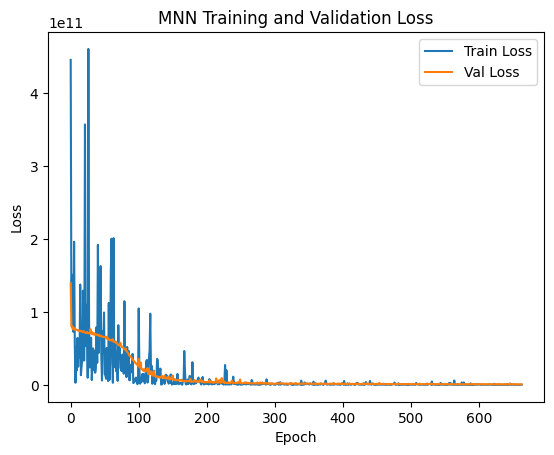

In [186]:
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_val, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MNN Training and Validation Loss')
plt.show()

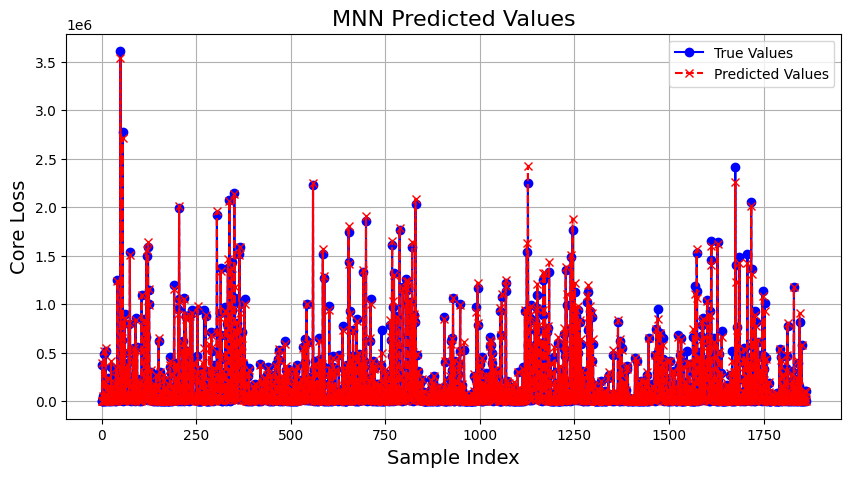

In [176]:
plt.figure(figsize=(10, 5))
plt.plot(real_values, label='True Values', marker='o', linestyle='-', color='blue')  
plt.plot(predictions, label='Predicted Values', marker='x', linestyle='--', color='red') 
plt.title('MNN Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Core Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [178]:
mse = mean_squared_error(real_values, predictions)
r2 = r2_score(real_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_values, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared (R²): {r2}')
print(f'MAE: {mae}')

Mean Squared Error (MSE): 593100352.0
RMSE: 593100352.0
R-squared (R²): 0.9949453908768159
MAE: 11490.76953125


In [180]:
predictions_np = np.array(predictions)
real_values_np = np.array(real_values)
mape = np.mean(np.abs((real_values_np-predictions_np) / real_values_np)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 20.25%


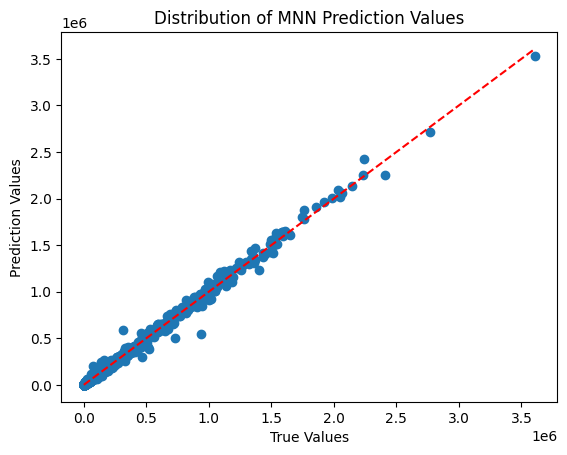

In [184]:
plt.scatter(c_loss_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Prediction Values')
plt.title('Distribution of MNN Prediction Values')
plt.plot([c_loss_test.min(), c_loss_test.max()], [c_loss_test.min(), c_loss_test.max()], 'r--')
plt.show()

In [166]:
torch.save(model, 'MNN.pth')